#**Tutorial 4 - DQN and Actor-Critic**

Please follow this tutorial to understand the structure (code) of DQNs & get familiar with Actor Critic methods.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed. 


##**Part 1: DQN**

In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 26 kB/s 
     |████████████████████████████████| 462 kB 59.4 MB/s 


In [3]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [4]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'CartPole-v0'
'MountainCar-v0'
'''

env = gym.make('CartPole-v0')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
[-0.04456399  0.04653909  0.01326909 -0.02099827]
----
0
----
[-0.04363321 -0.14877061  0.01284913  0.2758415 ]
1.0
False
{}
----


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components. 

### Q-Network:
The neural network used as a function approximator is defined below

In [5]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5) # ''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [6]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Truncation:
We add a line (optionally) in the code to truncate the gradient in hopes that it would help with the stability of the learning process.

## Tutorial Agent Code:


In [7]:
rewards_dqn_epsilon = []
rewards_dqn_softmax = []
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [49]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                 
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        
        scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
    return [np.array(scores),i_episode-100]

''' Trial run to check if algorithm runs and saves the data '''



' Trial run to check if algorithm runs and saves the data '

### **Task 1a**  
Understand the core of the algorithm, follow the flow of data. Identify the exploration strategy used.
### **Task 1b**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here. 
### **Task 1c**
How fast does the agent 'solve' the environment in terms of the number of episodes?
(CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials. SOURCE - https://gym.openai.com/envs/CartPole-v0/)

How 'well' does the agent learn? (reward plot?) The above two are some 'evaluation metrics' you can use to comment on the performance of an algorithm.

Please compare DQN (using $\epsilon$-greedy) with DQN (using softmax). Think along the lines of 'no. of episodes', 'reward plots', 'compute time', etc. and add a few comments.

### **Task 1d (Optional)** 

Take a look at the official submissions page on [OpenAI gym's CartPole v-0 evaluations](https://gym.openai.com/envs/CartPole-v0/) 




### **Solution to Task 1a**  
$ϵ$-greedy exploration strategy has already been implemented



### **Solution to Task 1b**


In [54]:
from scipy.special import softmax
class TutorialAgent_softmax():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, temp = 1):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' softmax action selection (newly implementing) '''
        #print(action_values.cpu().data.numpy().shape)
        prob = np.nan_to_num(softmax(action_values.cpu().data.numpy()[0]/temp))
        prob /= prob.sum()
        return np.random.choice(self.action_size, p = prob)
        
        


       

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [35]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn_softmax(n_episodes=10000, max_t=1000, temp_start= 10000, temp_end=1, temp_decay=0.995):

    scores = []                 
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    temp = temp_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, temp)
            #print(action)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        temp = temp*temp_decay
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        
        scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
    return [np.array(scores),i_episode-100]

''' Trial run to check if algorithm runs and saves the data '''



' Trial run to check if algorithm runs and saves the data '

### **Solution to Task 1c**

In [50]:
#running with epsilon-greedy strategy
begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)


[y_axis, x_axis] = dqn()



time_taken = datetime.datetime.now() - begin_time

print("Computation Time =" , time_taken)


Episode 100	Average Score: 36.05
Episode 200	Average Score: 121.77
Episode 300	Average Score: 83.87
Episode 400	Average Score: 96.93
Episode 500	Average Score: 77.29
Episode 600	Average Score: 95.80
Episode 700	Average Score: 87.41
Episode 800	Average Score: 133.35
Episode 900	Average Score: 55.30
Episode 1000	Average Score: 66.46
Episode 1100	Average Score: 192.80
Episode 1149	Average Score: 195.06
Environment solved in 1049 episodes!	Average Score: 195.06
Computation Time = 0:04:47.818102


In [51]:
y_axis1 = []
N_ep = len(y_axis)
for i in range(N_ep):
  idx = min(99,i)
  y_axis1.append(np.mean(y_axis[i-idx:i+1]))


In [48]:
begin_time = datetime.datetime.now()
agent = TutorialAgent_softmax(state_size=state_shape,action_size = action_shape,seed = 0)


[y_axis_softmax ,x_axis_softmax] = dqn_softmax()



time_taken_softmax = datetime.datetime.now() - begin_time

print(time_taken_softmax)

Episode 100	Average Score: 24.81
Episode 200	Average Score: 23.71
Episode 300	Average Score: 22.95
Episode 400	Average Score: 21.12
Episode 500	Average Score: 27.69
Episode 600	Average Score: 45.54
Episode 700	Average Score: 144.11
Episode 766	Average Score: 195.10
Environment solved in 666 episodes!	Average Score: 195.10
0:01:56.954879


In [52]:
y_axis2 = []
N_ep = len(y_axis)
for i in range(N_ep):
  idx = min(99,i)
  y_axis2.append(np.mean(y_axis_softmax[i-idx:i+1]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### *Comparing exploration strategies*
Computation Time => $ϵ$-greedy = 04:48
                 , softmax = 01:57 

No. of episodes till convergence =>	$ϵ$-greedy = 1049 , softmax = 666

Average score curves (moving average over last 100 scores) have been plotted below

Here, we get to see lesser number of epsiodes and lesser variance for the softmax exploration strategy. But to mark a clear winner, we need to conduct more varied experiments (subject to further tuning)

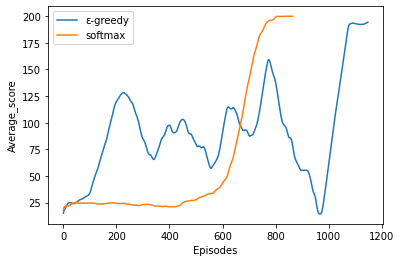

In [53]:
plt.xlabel('Episodes')
plt.ylabel('Average_score')
plt.plot(np.arange(len(y_axis1)) ,y_axis1)
plt.plot(np.arange(len(y_axis2)) ,y_axis2)
plt.legend(['\u03B5-greedy','softmax'])
plt.show()

#### **Submission Steps**

#### Task 1: Add a text cell with the answer.

#### Task 2: Add a code cell below task 1 solution and use 'Tutorial Agent Code' to build your new agent (with a different exploration strategy).

#### Task 3: Add a code cell below task 2 solution running both the agents to solve the CartPole v-0 environment and add a new text cell below it with your inferences.

## **Part 2: One-Step Actor-Critic Algorithm**

Recall: REINFORCE with baseline

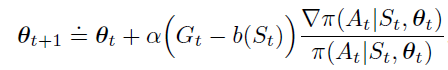

We can assign $b(S_t) = v_\pi(S_t)$

**Actor-Critic methods** learn both a policy $\pi(a|s;\theta)$ and a state-value function $v(s;w)$ simultaneously. The policy is referred to as the actor that suggests actions given a state. The estimated value function is referred to as the critic. It evaluates actions taken by the actor based on the given policy. In this exercise, both functions are approximated by feedforward neural networks. 

- The policy network is parametrized by $\theta$ - it takes a state $s$ as input and outputs the probabilities $\pi(a|s;\theta)\ \forall\ a$
- The value network is parametrized by $w$ - it takes a state $s$ as input and outputs a scalar value associated with the state, i.e., $v(s;w)$
- The single step TD error can be defined as follows:
$$\delta_t  = R_{t+1} + \gamma v(s_{t+1};w) - v(s_t;w)$$
- The loss function to be minimized at every step ($L_{tot}^{(t)}$) is a summation of two terms, as follows:
$$L_{tot}^{(t)} = L_{actor}^{(t)} + L_{critic}^{(t)}$$
where,
$$L_{actor}^{(t)} = -\log\pi(a_t|s_t; \theta)\delta_t$$
$$L_{critic}^{(t)} = \delta_t^2$$
- **NOTE: Here, weights of the first two hidden layers are shared by the policy and the value network**
    - First two hidden layer sizes: [1024, 512]
    - Output size of policy network: 2 (Softmax activation)
    - Output size of value network: 1 (Linear activation)

<!-- $$\pi(a|s;\theta) = \phi_{\theta}(a,s)$$ -->

### Initializing Actor-Critic Network

In [11]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

### Agent Class
###**Task 2a:** Write code to compute $\delta_t$ inside the Agent.learn() function



In [14]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            ##Add this line
            #V_s_next = tf.stop_gradient(V_s_next)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            

            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward + self.gamma*V_s_next - V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

### Train the Network

In [15]:
 env = gym.make('CartPole-v0')

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n)
#Number of episodes
episodes = 1000
tf.compat.v1.reset_default_graph()

reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0
    while not done:
        action = agent.sample_action(state) ##Sample Action
        next_state, reward, done, info = env.step(action) ##Take action
        next_state = next_state.reshape(1,-1)
        ep_rew += reward  ##Updating episode reward
        agent.learn(state, action, reward, next_state, done) ##Update Parameters
        state = next_state ##Updating State
    reward_list.append(ep_rew)

    if ep % 10 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > 195.0:
            print('Stopped at Episode ',ep-100)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward 33.000000 Average Reward 25.400000
Episode  20 Reward 28.000000 Average Reward 25.800000
Episode  30 Reward 52.000000 Average Reward 44.700000
Episode  40 Reward 82.000000 Average Reward 75.800000
Episode  50 Reward 47.000000 Average Reward 77.100000
Episode  60 Reward 55.000000 Average Reward 76.200000
Episode  70 Reward 63.000000 Average Reward 93.500000
Episode  80 Reward 70.000000 Average Reward 76.300000
Episode  90 Reward 72.000000 Average Reward 86.100000
Episode  100 Reward 122.000000 Average Reward 108.400000
Episode  110 Reward 70.000000 Average Reward 116.300000
Episode  120 Reward 175.000000 Average Reward 102.300000
Episode  130 Reward 91.000000 Average Reward 106.300000
Episode  140 Reward 109.000000 Average Reward 101.200000
Episode  150 Reward 180.000000 Average Reward 92.500000
Episode  160 Reward 142.000000 Average Reward 155.200000
Episode  170 Reward 200.000000 Average Reward 175.200000
Episode  180 Reward 166.000000 Average Reward 181.200000
Epis

### **Task 2b**: Plot total reward curve
In the cell below, write code to plot the total reward averaged over 100 episodes (moving average)

In [24]:
y_axis = []
N_ep = len(reward_list)
for i in range(N_ep):
  idx = min(99,i)
  y_axis.append(np.mean(reward_list[i-idx:i+1]))


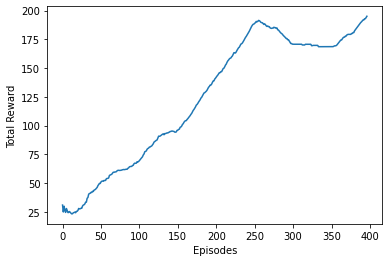

In [25]:
### Plot of total reward vs episode
## Write Code Below
plt.plot(np.arange(len(reward_list)),y_axis)
plt.ylabel('Total Reward')
plt.xlabel('Episodes')
plt.show()



### Code for rendering ([source](https://colab.research.google.com/drive/1D6bvoEVukil7DUaJU465vtfuDgLDbOY7#scrollTo=qbIMMkfmRHyC))

In [26]:
# Render an episode and save as a GIF file

display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))
    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, agent.ac_model, 200)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


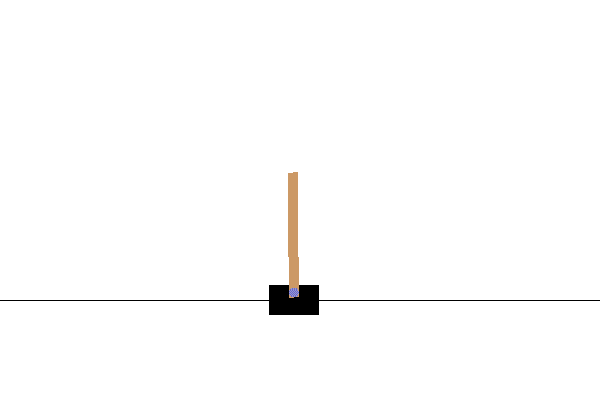

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)